This notebook is used to work with terrain features, specifically digital elevation data. It retrieves and processes elevation, slope, aspect, and other attributes from Google Earth Engine. The data is then saved for further analysis or visualization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime

## utils

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [ ]:
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='')

In [ ]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

## Terrain features

### point value downloading

The Shuttle Radar Topography Mission (SRTM, see Farr et al. 2007) digital elevation data is an international research effort that obtained digital elevation models on a near-global scale. This SRTM V3 product (SRTM Plus) is provided by NASA JPL at a resolution of 1 arc-second (approximately 30m).

This dataset has undergone a void-filling process using open-source data (ASTER GDEM2, GMTED2010, and NED), as opposed to other versions that contain voids or have been void-filled with commercial sources. For more information on the different versions see the SRTM Quick Guide.

* https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003

In [ ]:
def get_local_elevation_attributes(r_lon, r_lat, scale):
    # Fetch elevation, slope, aspect, and hillshade for a point of interest.
    dem = ee.Image('USGS/SRTMGL1_003').select('elevation');

    # Define the location of interest
    r_poi = ee.Geometry.Point(r_lon, r_lat)

    #Calculate slope. Units are degrees, range is [0,90).
    slope = ee.Terrain.slope(dem)

    #Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
    aspect = ee.Terrain.aspect(dem)

    # Use the ee.Terrain.products function to calculate slope, aspect, and
    # hillshade simultaneously. The output bands are appended to the input image.
    # Hillshade is calculated based on illumination azimuth=270, elevation=45.
    terrain = ee.Terrain.products(dem)

    #get the metadata of the band
    aspect_r_poi = aspect.sample(r_poi, scale).first().getInfo()
    slope_r_poi = slope.sample(r_poi, scale).first().getInfo()

    terrain_r_poi = terrain.sample(r_poi, scale).first().getInfo()

    # pd.DataFrame(terrain_r_poi['properties'], index=[0])
    aspect_v = aspect_r_poi['properties']['aspect']
    slope_v = slope_r_poi['properties']['slope']
    elevation_v = terrain_r_poi['properties']['elevation']
    hillshade_v = terrain_r_poi['properties']['hillshade']

    return aspect_v, slope_v, elevation_v, hillshade_v

In [ ]:
#basic example
r_lon, r_lat = 141.4377389809555, -30.95203025969217
scale = 30

aspect_v, slope_v, elevation_v, hillshade_v = get_local_elevation_attributes(r_lon, r_lat, scale)
aspect_v, slope_v, elevation_v, hillshade_v

(105.95345306396484, 3.3705644607543945, 162, 170)

The Copernicus DEM is a Digital Surface Model (DSM) which represents the surface of the Earth including buildings, infrastructure and vegetation. This DEM is derived from an edited DSM named WorldDEM&trade, i.e. flattening of water bodies and consistent flow of rivers has been included. Editing of shore- and coastlines, special features such as airports and implausible terrain structures has also been applied.

The WorldDEM product is based on the radar satellite data acquired during the TanDEM-X Mission, which is funded by a Public Private Partnership between the German State, represented by the German Aerospace Centre (DLR) and Airbus Defence and Space. More details are available in the dataset documentation.

Earth Engine asset has been ingested from the DGED files.

* https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_DEM_GLO30#description

In [ ]:
def get_local_elevation_attributes_north(r_lon, r_lat, scale):
    # Copernicus DEM GLO-30: Global 30m Digital Elevation Model
    dem = ee.ImageCollection('COPERNICUS/DEM/GLO30').select('DEM').median();

    # Define the location of interest
    r_poi = ee.Geometry.Point(r_lon, r_lat)

    #Calculate slope. Units are degrees, range is [0,90).
    slope = ee.Terrain.slope(dem)

    #Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
    aspect = ee.Terrain.aspect(dem)

    # Use the ee.Terrain.products function to calculate slope, aspect, and
    # hillshade simultaneously. The output bands are appended to the input image.
    # Hillshade is calculated based on illumination azimuth=270, elevation=45.
    terrain = ee.Terrain.products(dem)

    #get the metadata of the band
    aspect_r_poi = aspect.sample(r_poi, scale).first().getInfo()
    slope_r_poi = slope.sample(r_poi, scale).first().getInfo()

    terrain_r_poi = terrain.sample(r_poi, scale).first().getInfo()

    # pd.DataFrame(terrain_r_poi['properties'], index=[0])
    aspect_v = aspect_r_poi['properties']['aspect']
    slope_v = slope_r_poi['properties']['slope']
    elevation_v = terrain_r_poi['properties']['DEM']
    hillshade_v = terrain_r_poi['properties']['hillshade']

    return aspect_v, slope_v, elevation_v, hillshade_v

In [ ]:
#basic example
r_lon, r_lat = 141.4377389809555, -30.95203025969217
scale = 30

aspect_v, slope_v, elevation_v, hillshade_v = get_local_elevation_attributes_north(r_lon, r_lat, scale)
aspect_v, slope_v, elevation_v, hillshade_v

(306.55487060546875, 0.04144307225942612, 154.82156372070312, 180)

### DEM image downloading

In [ ]:
def get_dem_2d(aoi):
    # Fetch 2D Digital Elevation Model data for a specified area of interest.
    dem = (ee.ImageCollection('COPERNICUS/DEM/GLO30')
                .select('DEM')
                .filterBounds(aoi)
                .median())
    #using the median value of multi bands
    dem = dem.reproject(crs = ee.Projection('EPSG:4326'), scale=10)
    bands2d = dem.select('DEM').sampleRectangle(aoi)

    band_arr = bands2d.get('DEM')
    arr2d = np.array(band_arr.getInfo())

    return arr2d

In [ ]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
#downloading dem
demImg = get_dem_2d(aoi)
demImg.shape

(247, 479)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/data/"
np.save(path +"gee2Ddata/demImg.npy", demImg)

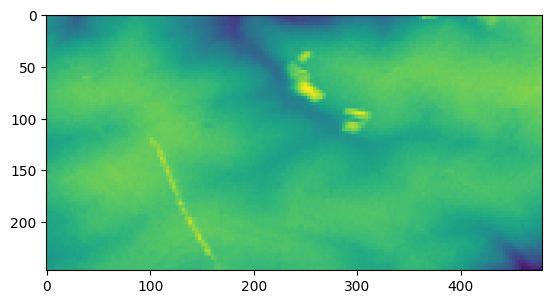

In [ ]:
plt.figure()
plt.imshow(demImg)